In [1]:
import numpy as np
from scipy.linalg import eigvals
import matplotlib.pyplot as plt
import networkx as nx

249.0


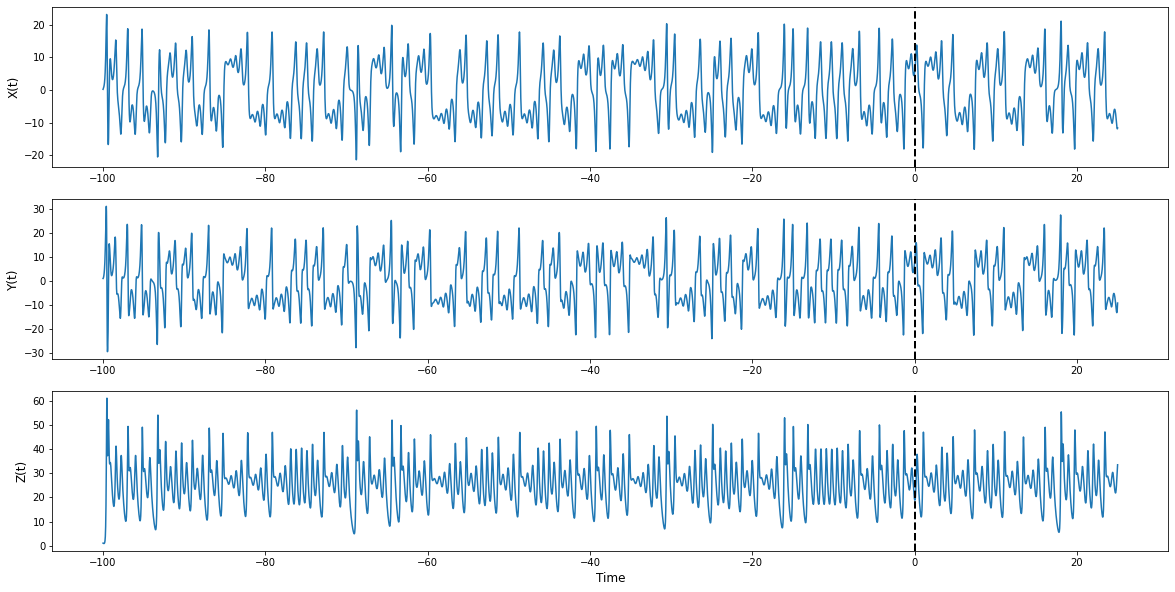

In [2]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

dt = 0.02
num_steps = 6250

print(5//0.02)

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)
    
traj = np.vstack((xs[1:],ys[1:],zs[1:]))
time = np.linspace(-100,25,num_steps)

fig, axs = plt.subplots(3,1, figsize=(20,10))
labels = ["X(t)", "Y(t)", "Z(t)"]
for k in range(3):
    axs[k].plot(time,traj[k])
    axs[k].axvline(0,lw=2,c="k",ls="--")
    axs[k].set_ylabel(labels[k], fontsize=12) 
plt.xlabel("Time", fontsize=12)
plt.show()

In [4]:
class ResNet():
    """ Reservoir Machine

    Parameters
    ------------
    N : int (default: 500)
        Number of nodes in the reservoir.
    M : int (default: 3 -> Lorenz system)
        Number of features in the input data.
    sigma : float (default: 0.1)
        Upper bound of the uniform distribution for input matrix Win
    spr : float (default: 1.)
        Spectral radius of the reservoir
    beta : float (default: 0.)
        Tikhonov regularization parameter
    alpha : float (default: 1.)
        Leakage rate, memory of the machine
    bias : float (default: 0.)
        Bias of the machine to help prediction
    seed : int (default=1)
        Seed for the RNG
    gamma : float (default=1.)
        Fraction of data going directly to Win
    """
    
    def __init__(self, N=500, M=3, sigma=0.1, degree=5, spr=1, beta=0, alpha=1, bias=0, seed=1, gamma=1):  
        self.N = N
        self.M = M
        self.sigma, self.alpha, self.beta, self.gamma = sigma, alpha, beta, gamma
        self.bias = bias
        self.rng = np.random.default_rng(seed)
        
        self.create_reservoir(degree, spr)
        
    def create_reservoir(self, degree, spr):
        #############
        #INPUT MATRIX
        #############
        self.Win = np.zeros((self.N,self.M))
        in_elt = self.rng.choice(self.M, self.N) #Choose randomly connected nodes
        in_coeffs = self.rng.uniform(-self.sigma, self.sigma, size=self.N) #Draw connection factor from uni. dist.
        for i, elt in enumerate(in_elt):
            self.Win[i,elt] = in_coeffs[i]
        
        ##########
        #RESERVOIR
        ##########
        reservoir = nx.erdos_renyi_graph(self.N, degree/self.N, directed=True)
        self.W = nx.adjacency_matrix(reservoir).todense()
        self.W = np.multiply(self.W, self.rng.uniform(-1,1,size=(self.N,self.N)))
        radius = max(abs(eigvals(self.W)))
        self.W *= spr/radius
        
    def train(self,data):
        T = np.max(data.shape)
        self.states = np.zeros((self.N,T))
        self.states[:,0] = self.Win @ data[:,0]
        for i in range(1,T):
            self.states[:,i] = (1-self.alpha)*self.states[:,i-1] +\
                               self.alpha*np.tanh(self.Win @ data[:,i-1] + self.W @ self.states[:,i-1] + self.bias)
        
    def compute_Wout(self,labels):
        self.Wout = (labels @ self.states.T) @ np.linalg.inv(self.states @ self.states.T \
                                                               + self.beta*np.eye(self.N))
        self.W_final = self.Win @ self.Wout + self.W
        
    def get_training(self):
        return self.Wout @ self.states

    def test(self,test,warmup=100):
        warm_state = np.zeros((self.N,warmup))
        for i in range(1,warmup):
            warm_state[:,i] = (1-self.alpha)*warm_state[:,i-1] +\
                         self.alpha*np.tanh(self.Win @ test[:,i-1] + self.W @ warm_state[:,i-1] + self.bias)
            
        self.test_states = np.zeros((self.N,test.shape[1]-warmup+1))
        self.test_states[:,0] = warm_state[:,-1]
        for i in range(1,test.shape[1]-warmup+1):
            self.test_states[:,i] = (1-self.alpha)*self.test_states[:,i-1] +\
                                    self.alpha*np.tanh(self.W_final @ self.test_states[:,i-1] + self.bias)
        
        return self.Wout @ self.test_states

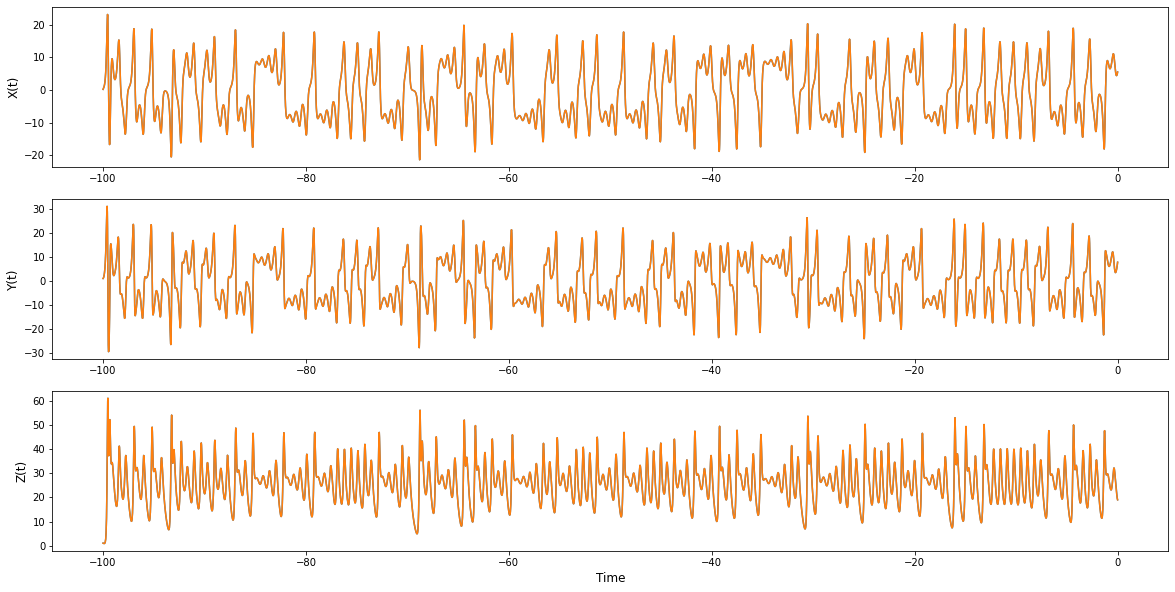

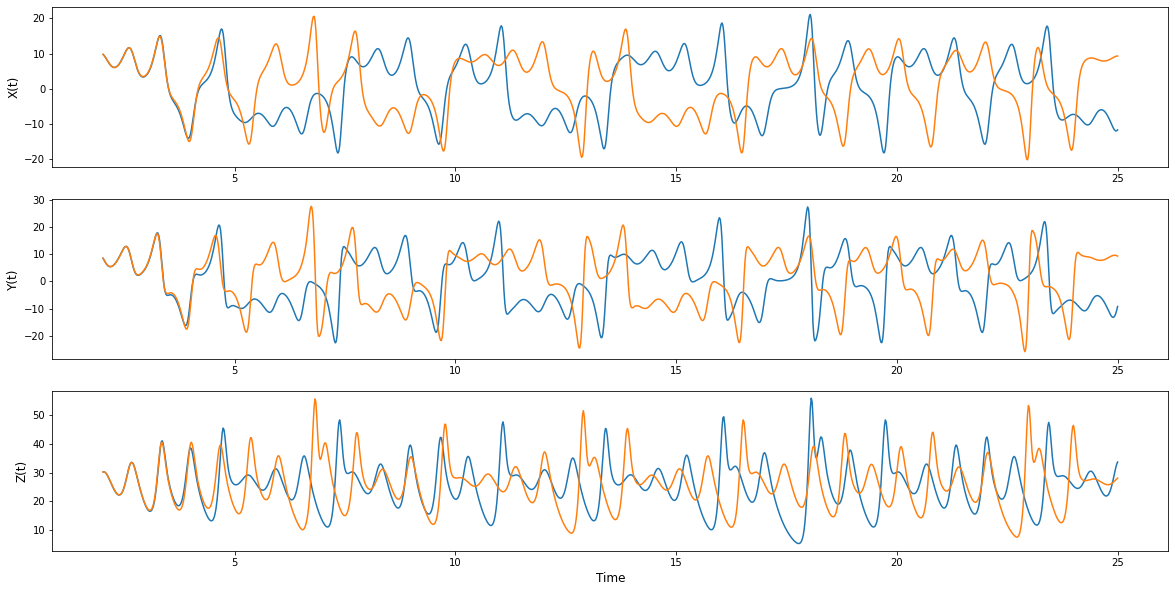

In [14]:
###############
#TRAINING PHASE
###############

resnet = ResNet(N=300, degree=6, spr=1.2)
resnet.train(traj[:,:5000])
resnet.compute_Wout(traj[:,:5000])
pred = resnet.get_training()

fig, axs = plt.subplots(3,1, figsize=(20,10))
labels = ["X(t)", "Y(t)", "Z(t)"]
for k in range(3):
    axs[k].plot(time[:5000],traj[k,:5000])
    axs[k].plot(time[:5000],pred[k])
    axs[k].set_ylabel(labels[k], fontsize=12) 
plt.xlabel("Time", fontsize=12)
plt.show()

###########
#TEST PHASE
###########

w = 100
pred_test = resnet.test(traj[:,5000:], warmup=w)

fig, axs = plt.subplots(3,1, figsize=(20,10))
for k in range(3):
    axs[k].plot(time[5000+w:], traj[k,5000+w:])
    axs[k].plot(time[5000+w:], pred_test[k,1:])
    axs[k].set_ylabel(labels[k], fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.show()